In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
def split_data(stock, lookback):
    data_raw = stock# convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback+1])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [3]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.1):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(out[:,-1])
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        return hidden
    
def train_mse(train_loader, test_loader, learn_rate, hidden_dim=64, EPOCHS=20, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    # Instantiating the models
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    
    # Defining loss function and optimizer
    criterion1 = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    mseloss_train = []
    mseloss_test = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
    
        start_time = time.perf_counter()
        h = model.init_hidden(batch_size)
        avg_loss1 = 0.
        for x, label in train_loader:
            length = len(train_loader)
            h = h.data
            model.zero_grad()

            out, h = model.forward(x.float(), h)
            loss1 = criterion1(out, label.float())
            loss1.backward()
           
            optimizer.step()
            avg_loss1 += loss1.item()
        
        avg_loss1 /= length
        mseloss_train.append(avg_loss1)
        print("Epoch {}/{} Done, Total Training MSELoss: {}".format(epoch, EPOCHS, avg_loss1))
        
        predictions = []
        values = []
        h = model.init_hidden(1)
        criterion1 = nn.MSELoss()
        
        loss1 = []
        for x, label in test_loader:
            length = len(test_loader)
            avg_loss1 = 0.
            h = h.data
            model.zero_grad()
    
            out, h = model.forward(x.float(), h)
            testloss = criterion1(out, label.float()).item()
            avg_loss1 += testloss
            
            predictions.append(out.detach().numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
            
        mseloss_test.append(avg_loss1)    
        print("Total Testing MSELoss: {}".format(testloss))
       
        current_time = time.perf_counter()
        epoch_times.append(current_time-start_time)
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        print()
        
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model, mseloss_train, mseloss_test, predictions, values

def train_l1(train_loader, test_loader, learn_rate, hidden_dim=64, EPOCHS=20, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    # Instantiating the models
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    
    # Defining loss function and optimizer
    criterion2 = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    l1loss_train = []
    l1loss_test = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
    
        start_time = time.perf_counter()
        h = model.init_hidden(batch_size)
        avg_loss2 = 0.
        for x, label in train_loader:
            length = len(train_loader)
            h = h.data
            model.zero_grad()

            out, h = model.forward(x.float(), h)
            
            loss2 = criterion2(out, label.float())
            loss2.backward()
            optimizer.step()
            avg_loss2 += loss2.item()
        
        avg_loss2 /= length
        l1loss_train.append(avg_loss2)
        print("Epoch {}/{} Done, Total Training L1Loss: {}".format(epoch, EPOCHS, avg_loss2))
        
        predictions = []
        values = []
        h = model.init_hidden(1)
        criterion2 = nn.L1Loss()
        
        loss2 = []
        for x, label in test_loader:
            length = len(test_loader)
            avg_loss2 = 0.
            h = h.data
            model.zero_grad()
    
            out, h = model.forward(x.float(), h)
            testloss = criterion2(out, label.float()).item()
            avg_loss2 += testloss
            predictions.append(out.detach().numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
        
        l1loss_test.append(avg_loss2)
        print("Total Testing L1Loss: {}".format(testloss))
       
        current_time = time.perf_counter()
        epoch_times.append(current_time-start_time)
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        print()
        
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model, l1loss_train, l1loss_test, predictions, values

def evaluate(model, test_loader):
    with torch.no_grad():
        predictions = []
        values = []
        h = model.init_hidden(1)
        criterion1 = nn.MSELoss()
        criterion2 = nn.L1Loss()
        
        loss1 = 0
        loss2 = 0
        for x, label in test_loader:
            h = h.data
            model.zero_grad()
    
            out, h = model.forward(x.float(), h)
            loss1 = criterion1(out, label.float()).item()
            loss2 = criterion2(out, label.float()).item()
            predictions.append(out.numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
            
        print("Total MSELoss: {}".format(loss1))
        print("Total L1Loss: {}".format(loss2))
        
            
    return predictions, values, loss1,loss2

## Artificial Dataset 1

In [4]:
art_data = pd.read_csv("Artificial_trend.csv")
art_data.set_index('date',inplace=True)
len(art_data)

7307

In [5]:
#data already ranges from -0.15 to 0.15, minmaxscale for consistent with other datasets
# Define lookback period and split inputs/labels
sc = MinMaxScaler()
label_sc = MinMaxScaler()
scaled_art1 = sc.fit_transform(art_data.values)


lookback = 5 # choose sequence length
train_x,train_y,test_x,test_y = split_data(scaled_art1, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (5842, 5, 1)
y_train.shape:  (5842, 1)
X_test.shape:  (1460, 5, 1)
y_test.shape:  (1460, 1)


In [6]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False,batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [7]:
lr = 0.001
art_model_mse, mseloss_train, mseloss_test, predictions, values = train_mse(train_loader, test_loader, lr, model_type="GRU")
art_model_l1, l1loss_train, l1loss_test, predictions, values = train_l1(train_loader, test_loader, lr, model_type="GRU")

Starting Training of GRU model


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/20 Done, Total Training MSELoss: 0.035117613041330806
Total Testing MSELoss: 0.0003068442747462541
Total Time Elapsed: 1.9635801270000006 seconds

Epoch 2/20 Done, Total Training MSELoss: 0.013608301765218909
Total Testing MSELoss: 0.0004457641625776887
Total Time Elapsed: 3.0787756270000006 seconds

Epoch 3/20 Done, Total Training MSELoss: 0.006721204333998785
Total Testing MSELoss: 0.001068789279088378
Total Time Elapsed: 2.950868433 seconds

Epoch 4/20 Done, Total Training MSELoss: 0.0019824481366143387
Total Testing MSELoss: 2.72885099548148e-05
Total Time Elapsed: 3.2510859780000008 seconds

Epoch 5/20 Done, Total Training MSELoss: 0.0005074061169020402
Total Testing MSELoss: 0.0002647569344844669
Total Time Elapsed: 1.9172733620000013 seconds

Epoch 6/20 Done, Total Training MSELoss: 0.0004106965331759836
Total Testing MSELoss: 0.00035847420804202557
Total Time Elapsed: 1.809676629000002 seconds

Epoch 7/20 Done, Total Training MSELoss: 0.00035328303184232335
Total Testin

In [8]:
#predictions, values, loss1,loss2 = evaluate(gru_model1,test_loader)

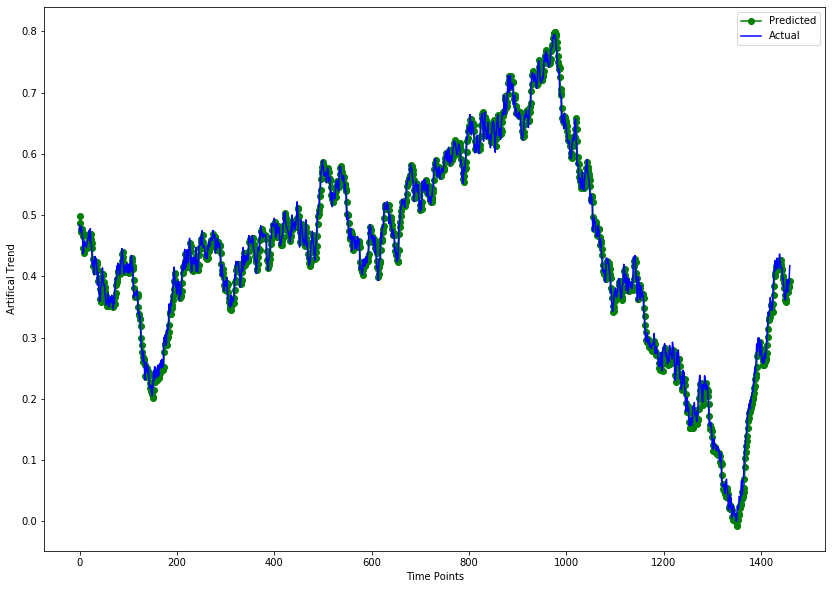

In [9]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artifical Trend')
plt.xlabel('Time Points')
plt.legend()

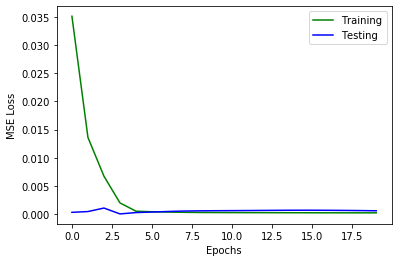

In [10]:
plt.plot(mseloss_train, color="g", label="Training")
plt.plot(mseloss_test, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

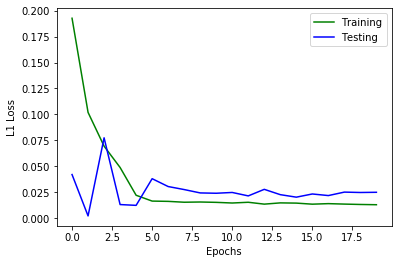

In [11]:
plt.plot(l1loss_train, color="g", label="Training")
plt.plot(l1loss_test, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Artificial Data 2

In [12]:
art_data2 = pd.read_csv("Artificial_trend1.csv")
art_data2.set_index('date',inplace=True)
len(art_data2)

7307

In [13]:
#data already ranges from -0.15 to 0.15, minmaxscale for consistent with other datasets
# Define lookback period and split inputs/labels
sc = MinMaxScaler()
label_sc = MinMaxScaler()
scaled_art2 = sc.fit_transform(art_data2.values)


lookback = 5 # choose sequence length
train_x,train_y,test_x,test_y = split_data(scaled_art2, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (5842, 5, 1)
y_train.shape:  (5842, 1)
X_test.shape:  (1460, 5, 1)
y_test.shape:  (1460, 1)


In [14]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False,batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [15]:
lr = 0.001
art_model_mse, mseloss_train, mseloss_test, predictions, values = train_mse(train_loader, test_loader, lr, model_type="GRU")
art_model_l1, l1loss_train, l1loss_test, predictions, values = train_l1(train_loader, test_loader, lr, model_type="GRU")

Starting Training of GRU model


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/20 Done, Total Training MSELoss: 0.04019713498188879
Total Testing MSELoss: 0.0922856330871582
Total Time Elapsed: 1.834237372000004 seconds

Epoch 2/20 Done, Total Training MSELoss: 0.017396888747148644
Total Testing MSELoss: 0.06858053058385849
Total Time Elapsed: 1.7983998429999986 seconds

Epoch 3/20 Done, Total Training MSELoss: 0.01007813380891713
Total Testing MSELoss: 0.03924813121557236
Total Time Elapsed: 1.8170403579999999 seconds

Epoch 4/20 Done, Total Training MSELoss: 0.003217458217737398
Total Testing MSELoss: 0.008039138279855251
Total Time Elapsed: 1.799876709000003 seconds

Epoch 5/20 Done, Total Training MSELoss: 0.0005784925654822203
Total Testing MSELoss: 0.001513920957222581
Total Time Elapsed: 1.8079698160000106 seconds

Epoch 6/20 Done, Total Training MSELoss: 0.00043187386712576213
Total Testing MSELoss: 0.0020555697847157717
Total Time Elapsed: 1.7871319070000027 seconds

Epoch 7/20 Done, Total Training MSELoss: 0.0004104728796736818
Total Testing MSE

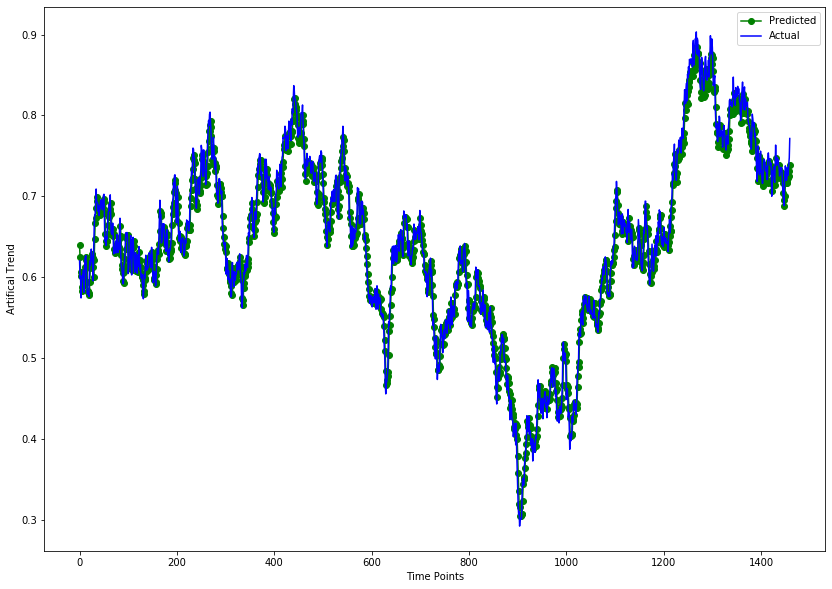

In [16]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artifical Trend')
plt.xlabel('Time Points')
plt.legend()

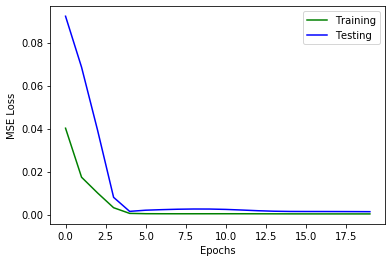

In [17]:
plt.plot(mseloss_train, color="g", label="Training")
plt.plot(mseloss_test, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

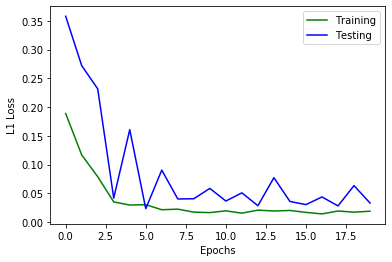

In [18]:
plt.plot(l1loss_train, color="g", label="Training")
plt.plot(l1loss_test, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Microsoft Stock

In [19]:
microsoft_df = pd.read_csv("Microsoft_Stock.csv")
microsoft_df['Date'] = pd.to_datetime(microsoft_df['Date'])
microsoft_df.set_index('Date',inplace=True)
microsoft_df.drop(columns=['Open','High','Low','Volume'],inplace=True)
microsoft_df

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42
...,...
2021-03-25 16:00:00,232.34
2021-03-26 16:00:00,236.48
2021-03-29 16:00:00,235.24


In [20]:
# Scaling the input data
sc = MinMaxScaler()
label_sc = MinMaxScaler()
scaled_micro = sc.fit_transform(microsoft_df.values)
# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
#label_sc.fit(microsoft_df.iloc[:,0].values.reshape(-1,1))

train_x,train_y,test_x,test_y = split_data(scaled_micro, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1205, 5, 1)
y_train.shape:  (1205, 1)
X_test.shape:  (301, 5, 1)
y_test.shape:  (301, 1)


In [21]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [22]:
lr = 0.001
gru_model2, mseloss_train, mseloss_test,predictions, values = train_mse(train_loader, test_loader,lr, model_type="GRU")
gru_model2, l1loss_train, l1loss_test,predictions, values = train_l1(train_loader, test_loader,lr, model_type="GRU")

Starting Training of GRU model
Epoch 1/20 Done, Total Training MSELoss: 0.0014117327183477166


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.16872847080230713
Total Time Elapsed: 0.46831956699998045 seconds

Epoch 2/20 Done, Total Training MSELoss: 0.03901356792266597
Total Testing MSELoss: 0.25317394733428955
Total Time Elapsed: 0.4225041790000148 seconds

Epoch 3/20 Done, Total Training MSELoss: 0.02032435714578684
Total Testing MSELoss: 0.18495029211044312
Total Time Elapsed: 0.42454932499998677 seconds

Epoch 4/20 Done, Total Training MSELoss: 0.009215697043908073
Total Testing MSELoss: 0.045276571065187454
Total Time Elapsed: 0.4238055829999894 seconds

Epoch 5/20 Done, Total Training MSELoss: 0.003832277570099167
Total Testing MSELoss: 0.002620753599330783
Total Time Elapsed: 0.4214176769999938 seconds

Epoch 6/20 Done, Total Training MSELoss: 0.00010837280760333178
Total Testing MSELoss: 0.001374041778035462
Total Time Elapsed: 0.41266281700001173 seconds

Epoch 7/20 Done, Total Training MSELoss: 0.0002703694005774466
Total Testing MSELoss: 0.00027414734358899295
Total Time Elapsed: 0.4155664

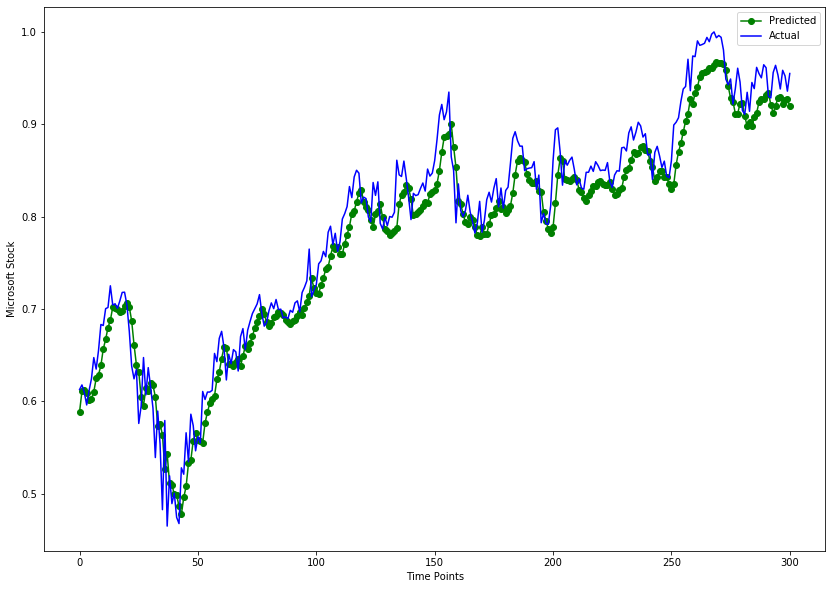

In [23]:
#predictions, values,loss1,loss2 = evaluate(gru_model2,test_loader)

plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Microsoft Stock')
plt.xlabel('Time Points')
plt.legend()

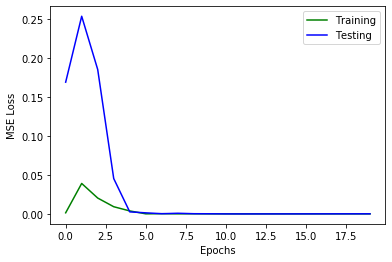

In [24]:
plt.plot(mseloss_train, color="g", label="Training")
plt.plot(mseloss_test, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

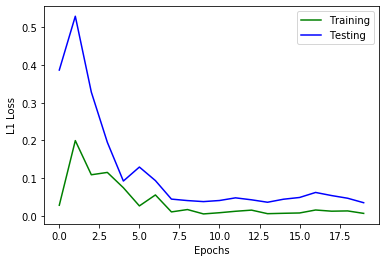

In [25]:
plt.plot(l1loss_train, color="g", label="Training")
plt.plot(l1loss_test, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Crude Oil 

In [26]:
oil_df = pd.read_csv("oil.csv")
oil_df['DATE'] = pd.to_datetime(oil_df['DATE'])
oil_df.set_index('DATE',inplace=True)
for index, oil in enumerate(oil_df["DCOILBRENTEU"]):
    if oil == ".":
        oil_df["DCOILBRENTEU"][index] = None
oil_df.dropna(inplace=True)
oil_df

,DCOILBRENTEU
DATE,
2015-11-02,47.91
2015-11-03,48.00
2015-11-04,46.96
2015-11-05,47.19
2015-11-06,46.09
...,...
2021-10-26,85.11
2021-10-27,84.12
2021-10-28,83.4


In [27]:
# Scaling the input data
sc = MinMaxScaler()
#label_sc = MinMaxScaler()
scaled_oil = sc.fit_transform(oil_df.values)
# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
#label_sc.fit(microsoft_df.iloc[:,0].values.reshape(-1,1))

train_x,train_y,test_x,test_y = split_data(scaled_oil, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1219, 5, 1)
y_train.shape:  (1219, 1)
X_test.shape:  (305, 5, 1)
y_test.shape:  (305, 1)


In [28]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [29]:
lr = 0.001
gru_model3, mseloss_train, mseloss_test,predictions, values = train_mse(train_loader, test_loader,lr, model_type="GRU")
gru_model3, l1loss_train, l1loss_test,predictions, values = train_l1(train_loader, test_loader,lr, model_type="GRU")

Starting Training of GRU model


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/20 Done, Total Training MSELoss: 0.06660995644204759
Total Testing MSELoss: 0.15670879185199738
Total Time Elapsed: 0.5236367739999821 seconds

Epoch 2/20 Done, Total Training MSELoss: 0.046634646512469964
Total Testing MSELoss: 0.02667887508869171
Total Time Elapsed: 0.42217184800000496 seconds

Epoch 3/20 Done, Total Training MSELoss: 0.03981949425896777
Total Testing MSELoss: 0.019193537533283234
Total Time Elapsed: 0.4238391579999927 seconds

Epoch 4/20 Done, Total Training MSELoss: 0.029885862760956547
Total Testing MSELoss: 0.017446832731366158
Total Time Elapsed: 0.42406736000000933 seconds

Epoch 5/20 Done, Total Training MSELoss: 0.02486168081859911
Total Testing MSELoss: 0.01381748728454113
Total Time Elapsed: 0.4289603849999821 seconds

Epoch 6/20 Done, Total Training MSELoss: 0.021179548734308856
Total Testing MSELoss: 0.010465019382536411
Total Time Elapsed: 0.42870714700001145 seconds

Epoch 7/20 Done, Total Training MSELoss: 0.017884096899682556
Total Testing MSE

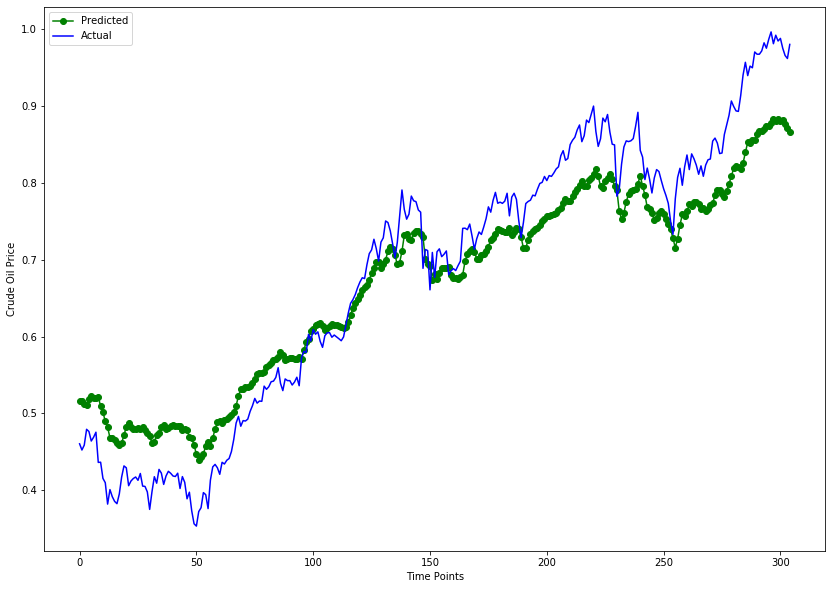

In [30]:
#predictions, values,loss1,loss2  = evaluate(gru_model3,test_loader)

plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Crude Oil Price')
plt.xlabel('Time Points')
plt.legend()

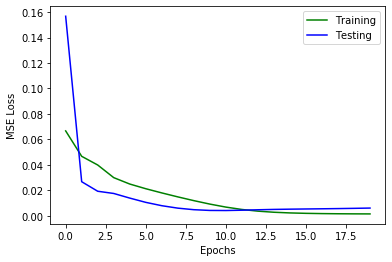

In [31]:
plt.plot(mseloss_train, color="g", label="Training")
plt.plot(mseloss_test, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

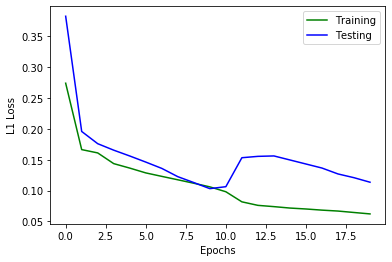

In [32]:
plt.plot(l1loss_train, color="g", label="Training")
plt.plot(l1loss_test, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

# Bitcoin

In [33]:
coin_df = pd.read_csv("coin.csv")
coin_df['Date'] = pd.to_datetime(coin_df['Date'])
coin_df.set_index('Date',inplace=True)
coin_df = pd.DataFrame(coin_df['Close'])
coin_df.dropna(inplace=True)
coin_df

,Close
Date,
2013-04-29 23:59:59,144.539993
2013-04-30 23:59:59,139.000000
2013-05-01 23:59:59,116.989998
2013-05-02 23:59:59,105.209999
2013-05-03 23:59:59,97.750000
...,...
2021-07-02 23:59:59,33897.048590
2021-07-03 23:59:59,34668.548402
2021-07-04 23:59:59,35287.779766


In [34]:
# Scaling the input data
sc = MinMaxScaler()
#label_sc = MinMaxScaler()
scaled_coin = sc.fit_transform(coin_df.values)
# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
#label_sc.fit(microsoft_df.iloc[:,0].values.reshape(-1,1))

train_x,train_y,test_x,test_y = split_data(scaled_coin, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (2389, 5, 1)
y_train.shape:  (2389, 1)
X_test.shape:  (597, 5, 1)
y_test.shape:  (597, 1)


In [35]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [36]:
lr = 0.001
gru_model4, mseloss_train, mseloss_test,predictions, values = train_mse(train_loader, test_loader,lr, model_type="GRU")
gru_model4, l1loss_train, l1loss_test,predictions, values = train_l1(train_loader, test_loader,lr, model_type="GRU")

Starting Training of GRU model


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/20 Done, Total Training MSELoss: 0.0020623341924874694
Total Testing MSELoss: 0.14878015220165253
Total Time Elapsed: 0.7963153150000153 seconds

Epoch 2/20 Done, Total Training MSELoss: 0.006241240834494444
Total Testing MSELoss: 0.15290573239326477
Total Time Elapsed: 0.7537221709999926 seconds

Epoch 3/20 Done, Total Training MSELoss: 0.007023503154611004
Total Testing MSELoss: 0.17767676711082458
Total Time Elapsed: 0.7483180920000052 seconds

Epoch 4/20 Done, Total Training MSELoss: 0.004206248711189137
Total Testing MSELoss: 0.15076015889644623
Total Time Elapsed: 0.7597632930000202 seconds

Epoch 5/20 Done, Total Training MSELoss: 0.00348828302284764
Total Testing MSELoss: 0.12027236819267273
Total Time Elapsed: 0.7438989510000056 seconds

Epoch 6/20 Done, Total Training MSELoss: 0.0030966103899904614
Total Testing MSELoss: 0.08932651579380035
Total Time Elapsed: 0.7422549409999988 seconds

Epoch 7/20 Done, Total Training MSELoss: 0.0025931199077683224
Total Testing MSEL

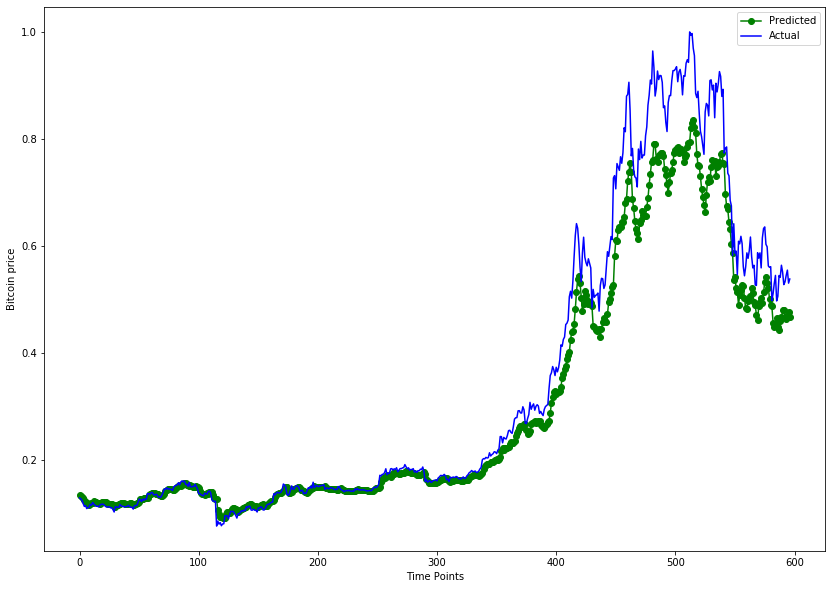

In [37]:
#predictions, values,loss1,loss2= evaluate(gru_model4,test_loader)

plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Bitcoin price')
plt.xlabel('Time Points')
plt.legend()

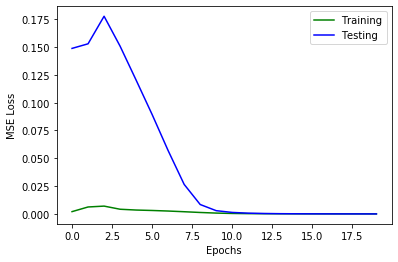

In [38]:
plt.plot(mseloss_train, color="g", label="Training")
plt.plot(mseloss_test, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

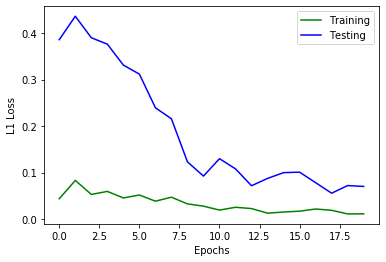

In [39]:
plt.plot(l1loss_train, color="g", label="Training")
plt.plot(l1loss_test, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

# S&P500

In [40]:
sp500_df = pd.read_csv("sp500.csv")
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])
sp500_df.set_index('Date',inplace=True)
sp500_df = pd.DataFrame(sp500_df['SP500'])
sp500_df.dropna(inplace=True)
sp500_df

,SP500
Date,
1871-01-01,4.44
1871-02-01,4.50
1871-03-01,4.61
1871-04-01,4.74
1871-05-01,4.86
...,...
2017-12-01,2664.34
2018-01-01,2789.80
2018-02-01,2705.16


In [41]:
# Scaling the input data
sc = MinMaxScaler()
#label_sc = MinMaxScaler()
scaled_sp = sc.fit_transform(sp500_df.values)
# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
#label_sc.fit(microsoft_df.iloc[:,0].values.reshape(-1,1))

train_x,train_y,test_x,test_y = split_data(scaled_sp, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1410, 5, 1)
y_train.shape:  (1410, 1)
X_test.shape:  (353, 5, 1)
y_test.shape:  (353, 1)


In [42]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [43]:
lr = 0.001
gru_model5, mseloss_train, mseloss_test,predictions, values = train_mse(train_loader, test_loader,lr, model_type="GRU")
gru_model5, l1loss_train, l1loss_test,predictions, values = train_l1(train_loader, test_loader,lr, model_type="GRU")

Starting Training of GRU model


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/20 Done, Total Training MSELoss: 0.002502564264845701
Total Testing MSELoss: 0.7930334806442261
Total Time Elapsed: 0.534801888000004 seconds

Epoch 2/20 Done, Total Training MSELoss: 0.00046388246783056854
Total Testing MSELoss: 0.7123622298240662
Total Time Elapsed: 0.48801267199999643 seconds

Epoch 3/20 Done, Total Training MSELoss: 0.0005128506569947303
Total Testing MSELoss: 0.6569952964782715
Total Time Elapsed: 0.4892153360000009 seconds

Epoch 4/20 Done, Total Training MSELoss: 0.0004571854088081554
Total Testing MSELoss: 0.6102437973022461
Total Time Elapsed: 0.49183582100002354 seconds

Epoch 5/20 Done, Total Training MSELoss: 0.00042104153062506487
Total Testing MSELoss: 0.5690377354621887
Total Time Elapsed: 0.4875678279999818 seconds

Epoch 6/20 Done, Total Training MSELoss: 0.00039419010081913217
Total Testing MSELoss: 0.5324509143829346
Total Time Elapsed: 0.48143751699998916 seconds

Epoch 7/20 Done, Total Training MSELoss: 0.0003718177900534737
Total Testing M

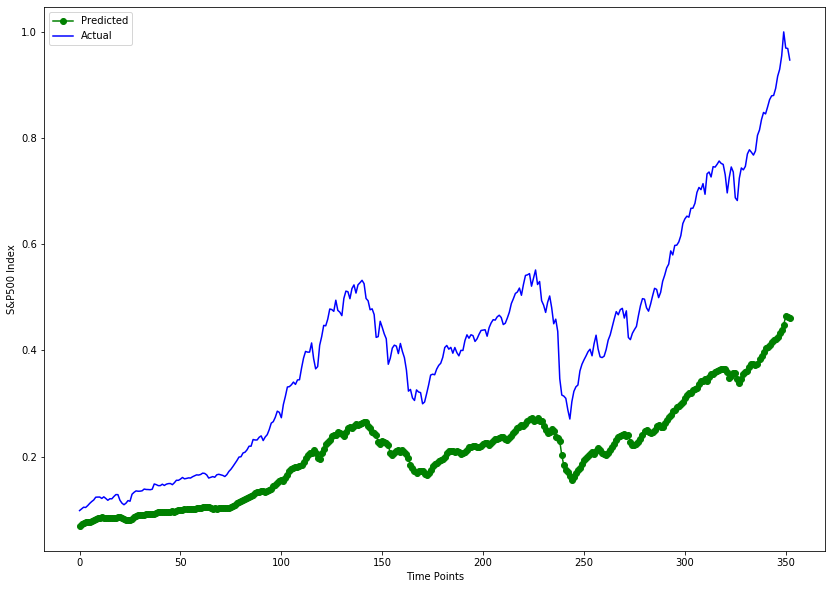

In [44]:
#predictions, values,loss1,loss2 = evaluate(gru_model5,test_loader)

plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('S&P500 Index')
plt.xlabel('Time Points')
plt.legend()

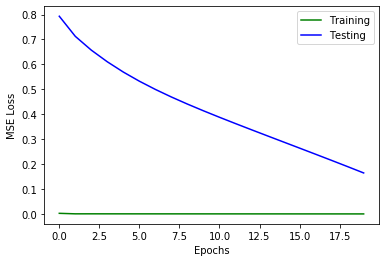

In [45]:
plt.plot(mseloss_train, color="g", label="Training")
plt.plot(mseloss_test, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

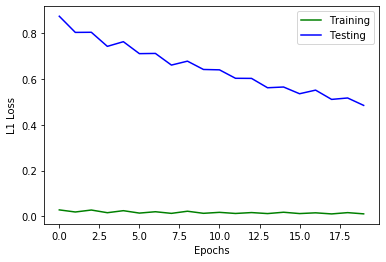

In [46]:
plt.plot(l1loss_train, color="g", label="Training")
plt.plot(l1loss_test, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()